In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = './data/catanddog/train'

transfrom = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transfrom)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(len(train_dataset))

385


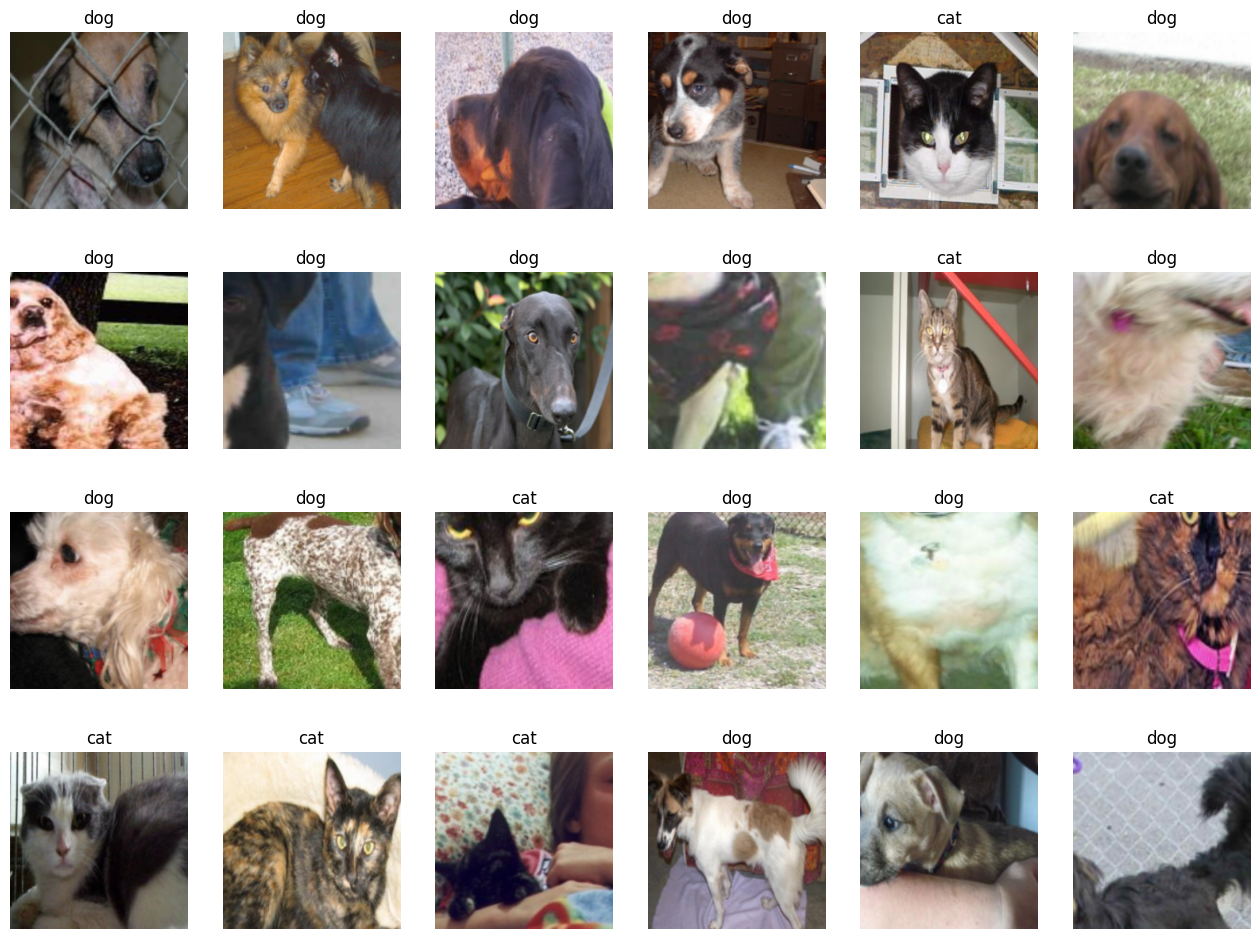

In [3]:
samples, labels = next(iter(train_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [4]:
resnet18 = models.resnet18(pretrained=True)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [6]:
resnet18.fc = nn.Linear(512, 2)

In [7]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-4.5366e-05,  2.5623e-02,  3.0951e-02,  ...,  4.2742e-02,
          3.6555e-02,  9.2191e-03],
        [ 1.9615e-02, -2.0525e-02,  2.5084e-03,  ...,  4.7076e-03,
         -3.5054e-02, -9.5829e-03]])
fc.bias tensor([-0.0255,  0.0133])


In [8]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad_(False)
    
model.fc = nn.Linear(512, 1)
for param in model.fc.parameters():
    param.requires_grad_(True)

optim = optim.Adam(model.fc.parameters())
criterion = nn.BCEWithLogitsLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def train_model(model, dataloaders, criterion, optim, device, num_epochs=13, is_train=True):
    
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs-1}')
        print('-' * 10)
        
        running_loss = 0.0
        running_corr = 0
        
        for inputs, labels in dataloaders:
            optim.zero_grad()
            outputs = model(inputs.to(device))
            labels = labels.unsqueeze(1).float().to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
            
            preds = (outputs >= 0.5).int()
            running_loss += loss.item() * inputs.size(0)
            running_corr += preds.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corr / len(dataloaders.dataset)
        
        print(f'Loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc)
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./model/', f'{epoch:02d}.pth'))
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')
    
    return acc_history, loss_history

In [10]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optim, device)

Epoch 0 / 12
----------
Loss : 0.6678 Acc: 0.6000

Epoch 1 / 12
----------
Loss : 0.5015 Acc: 0.7636

Epoch 2 / 12
----------
Loss : 0.4180 Acc: 0.8935

Epoch 3 / 12
----------
Loss : 0.4055 Acc: 0.7481

Epoch 4 / 12
----------
Loss : 0.3580 Acc: 0.8883

Epoch 5 / 12
----------
Loss : 0.3436 Acc: 0.8312

Epoch 6 / 12
----------
Loss : 0.3118 Acc: 0.8182

Epoch 7 / 12
----------
Loss : 0.3234 Acc: 0.8805

Epoch 8 / 12
----------
Loss : 0.2870 Acc: 0.8805

Epoch 9 / 12
----------
Loss : 0.2504 Acc: 0.9221

Epoch 10 / 12
----------
Loss : 0.2620 Acc: 0.9117

Epoch 11 / 12
----------
Loss : 0.2674 Acc: 0.8779

Epoch 12 / 12
----------
Loss : 0.2517 Acc: 0.9195

Training complete in 0m 10s
Best Acc: 0.922078


In [11]:
test_path = './data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(len(test_dataset))

98


In [12]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_model = glob.glob('./model/' + '*.pth')
    saved_model.sort()
    print('saved_model', saved_model)
    
    for model_path in saved_model:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corr = 0
        
        for inputs, labels in dataloaders:
            with torch.no_grad():
                outputs = model(inputs.to(device))
                
            preds = (outputs >= 0.5).int()
            running_corr += preds.eq(labels.unsqueeze(1).to(device)).sum().item()
        
        epoch_acc = running_corr / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc*100}%')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc)
        print()
    
    time_elapsed = time.time() - since
    print(f'Test complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')
    
    return acc_history

In [13]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['./model/00.pth', './model/01.pth', './model/02.pth', './model/03.pth', './model/04.pth', './model/05.pth', './model/06.pth', './model/07.pth', './model/08.pth', './model/09.pth', './model/10.pth', './model/11.pth', './model/12.pth']
Loading model ./model/00.pth
Acc: 72.44897959183673%

Loading model ./model/01.pth


/tmp/ipykernel_289494/4024686190.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 91.83673469387756%

Loading model ./model/02.pth
Acc: 89.79591836734694%

Loading model ./model/03.pth
Acc: 89.79591836734694%

Loading model ./model/04.pth
Acc: 91.83673469387756%

Loading model ./model/05.pth
Acc: 87.75510204081633%

Loading model ./model/06.pth
Acc: 94.89795918367348%

Loading model ./model/07.pth
Acc: 90.81632653061224%

Loading model ./model/08.pth
Acc: 94.89795918367348%

Loading model ./model/09.pth
Acc: 94.89795918367348%

Loading model ./model/10.pth
Acc: 95.91836734693877%

Loading model ./model/11.pth
Acc: 94.89795918367348%

Loading model ./model/12.pth
Acc: 93.87755102040816%

Test complete in 0m 2s
Best Acc: 0.959184


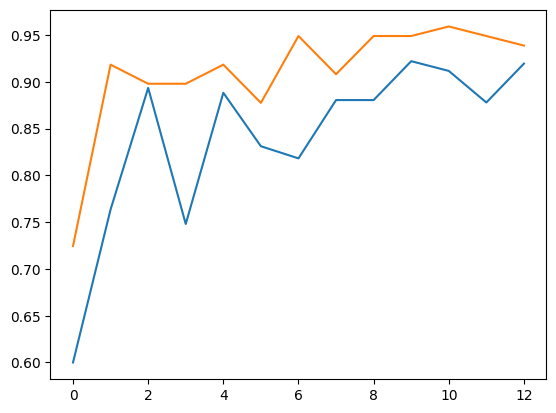

In [14]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

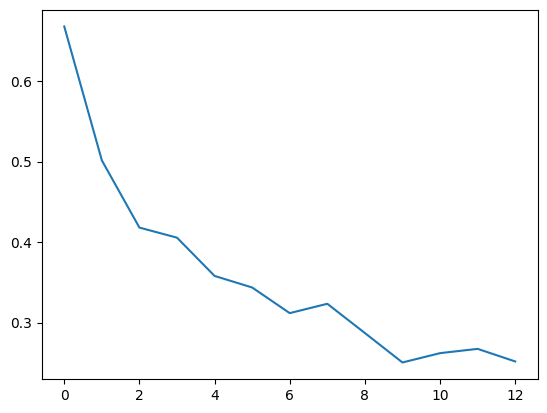

In [15]:
plt.plot(train_loss_hist)
plt.show()

In [16]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    image = image * std + mean
    image = image.clip(0, 1)
    return image

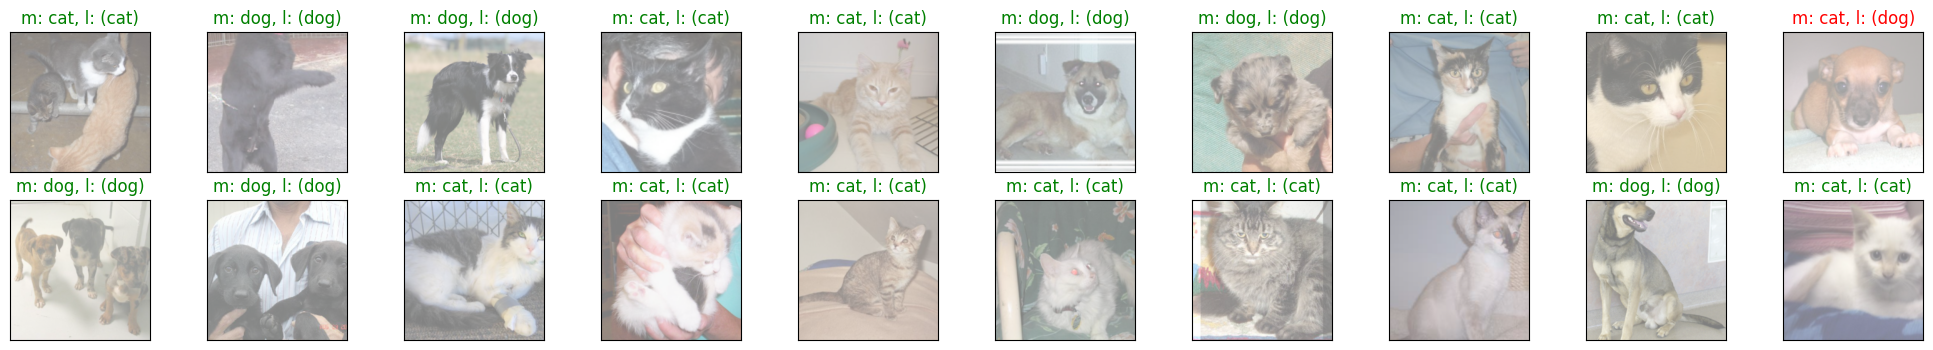

<Figure size 640x480 with 0 Axes>

In [19]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images.to(device))
preds = (output >= 0.5).int()

fig = plt.figure(figsize=(25,4))


for i in np.arange(20):
    axes = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    axes.set_title(f'm: {str(classes[preds[i].item()])}, l: ({str(classes[labels[i].item()])})', color=('green' if preds[i]==labels[i] else 'red'))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)